# Pedestal Estimation from GSFC Calibration Images

In [1]:
import pathlib
import astropy.units as u
import astropy.io.fits
import xarray
import matplotlib.pyplot as plt
import numpy as np
import dask.array
import pandas
import tqdm

In [2]:
data_dir = pathlib.Path('../data/moxsi_gsfc_calibration_images/')

In [3]:
all_fits_files = sorted(data_dir.glob('csie_image_*.bin.fits'))
# Skip the first file due to uncertainty in the true exposure time
all_fits_files = all_fits_files[1:]

In [4]:
len(all_fits_files)

4598

In [5]:
# scale=True is for "det0", which is the detector temperature
def steinharthart(coeff, scale=False):
    def func(dn):
        r = dn / (4096 - dn)
        if scale:
            r *= 10000
        result = 1 / np.poly1d(coeff[::-1])(np.log(r)) - 273.15
        return result
    return func

In [6]:
# These are the Steinhart-Hart functions, which we will use
det0temp_sh = steinharthart([1.1292E-03, 2.3411E-04, 0.0000E+00, 8.7755E-08], scale=True)
det1temp_sh = steinharthart([3.3540E-03, 2.5708E-04, 1.8939E-06, 1.8973E-07])
fpgatemp_sh = steinharthart([3.3540E-03, 2.5708E-04, 1.8939E-06, 1.8973E-07])
thermadc_sh = steinharthart([3.3540E-03, 3.0013E-04, 5.0852E-06, 2.1877E-07])

What if we first wrote all of the data arrays to a Zarr array and then just read in the metadata from the original FITS files?

In [7]:
data = np.empty((len(all_fits_files),2000,1504))
temp_det_1 = []
temp_det_0 = []
temp_adc = []
exposure_time = []
time = []
meta_keys = [
    'DET0TEMP', 'DET1TEMP', 'THERMADC', 'FPGATEMP', 'EXPTIME', 'DATE', 'FRAME_ID'
]
meta_arrays = {k: [] for k in meta_keys}
for i,filename in enumerate(tqdm.tqdm(all_fits_files)):
    with astropy.io.fits.open(filename, memmap=False) as hdul:
        _header = hdul[0].header
        data[i,...] = hdul[0].data[:2000,:]  #disregard extra row
    for k in meta_arrays.keys():
        meta_arrays[k].append(_header[k])
time_coord = pandas.to_datetime(meta_arrays['DATE'])
data = dask.array.from_array(data,
                             chunks=(None, data.shape[1]//10, data.shape[2]//10))
ds = xarray.Dataset(
    {
        'data': (["sample", "row", "column"], data),
        'temperature_detector_0': (["sample"], np.array(meta_arrays['DET0TEMP'])),
        'temperature_detector_1': (["sample"], np.array(meta_arrays['DET1TEMP'])),
        'temperature_adc': (["sample"], np.array(meta_arrays['THERMADC'])),
        'temperature_fpga': (["sample"], np.array(meta_arrays['FPGATEMP'])),
        'exposure_time': (["sample"], np.array(meta_arrays['EXPTIME'])),
    },
    coords={
        "time": (["sample"], time_coord),
        "frame_id": (["sample"], np.array(meta_arrays['FRAME_ID']))
    }
)
# Apply conversion functions for temperature
ds['temperature_detector_0'].data = det0temp_sh(ds['temperature_detector_0'])
ds['temperature_detector_1'].data = det1temp_sh(ds['temperature_detector_1'])
ds['temperature_adc'].data = thermadc_sh(ds['temperature_adc'])
ds['temperature_fpga'].data = fpgatemp_sh(ds['temperature_fpga'])
# Correct exposure time
exptime_fixed = np.empty_like(ds['exposure_time'].data)
exptime_fixed[:414] = np.where(ds['exposure_time'].data[:414] == 1250, 5000, 1250)
exptime_fixed[414:] = np.where(
    ds['exposure_time'].data[414:] == 2500,
    1250,
    np.where(ds['exposure_time'].data[414:] == 5000, 2500, 5000)
)
exptime_fixed[614] = 5000  # this single image needs to be separately fixed
ds['exposure_time'].data = exptime_fixed
# Add unit information
ds['data'].attrs['unit'] = 'DN'
for k in ['detector_0', 'detector_1', 'adc', 'fpga']:
    ds[f'temperature_{k}'].attrs['unit'] = 'deg C'
ds['exposure_time'].attrs['unit'] = 'ms'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4598/4598 [00:37<00:00, 121.29it/s]


NameError: name '_data' is not defined

In [8]:
ds['data']

<xarray.DataArray 'data' (sample: 700, row: 2000, column: 1504)>
dask.array<array, shape=(700, 2000, 1504), dtype=uint16, chunksize=(700, 200, 150), chunktype=numpy.ndarray>
Coordinates:
    time      (sample) datetime64[ns] 2025-09-30T18:23:10.788942 ... 2025-09-...
    frame_id  (sample) int64 53598 53599 53600 53601 ... 54294 54295 54296 54297
Dimensions without coordinates: sample, row, column
Attributes:
    unit:     DN

In [ ]:
ds.where(ds.exposure_time==1250)

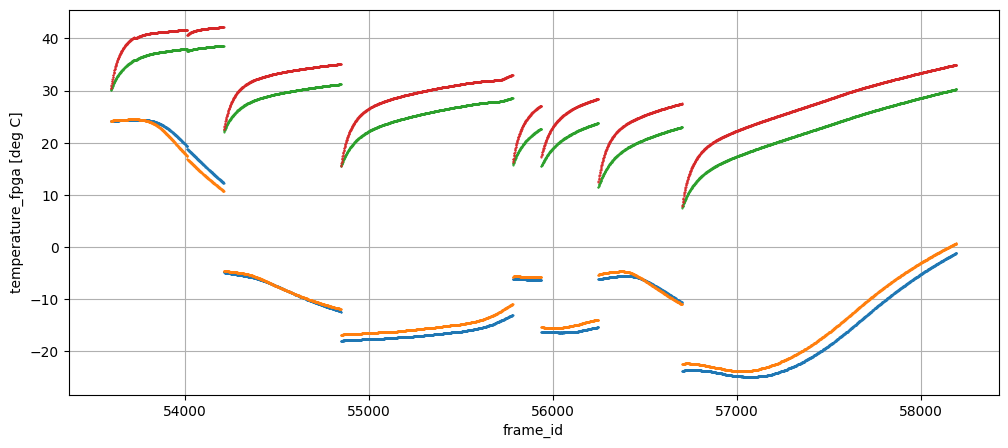

In [23]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot()
ax.grid()
ds['temperature_detector_0'].plot(x='frame_id',ls='',marker='.', markersize=1)
ds['temperature_detector_1'].plot(x='frame_id',ls='',marker='.', markersize=1)
ds['temperature_adc'].plot(x='frame_id',ls='',marker='.',markersize=1)
ds['temperature_fpga'].plot(x='frame_id',ls='',marker='.',markersize=1)

In [79]:
ds['exposure_time'

{}

In [82]:
_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1504                                                  
NAXIS2  =                 2001                                                  
EXTEND  =                    T                                                  
BSCALE  =                    1                                                  
BZERO   =                32768                                                  
DATE    = '2025-09-30T18:28:16.677933' / UTC time of this HDU's creation        
META_SEP= '******************** CSIE METADATA ********************'             
SHCOARSE=                  332 / [s] frame timestamp seconds                    
SHFINE  =                  797 / [ms] frame timestamp subseconds                
FRAME_ID=                536

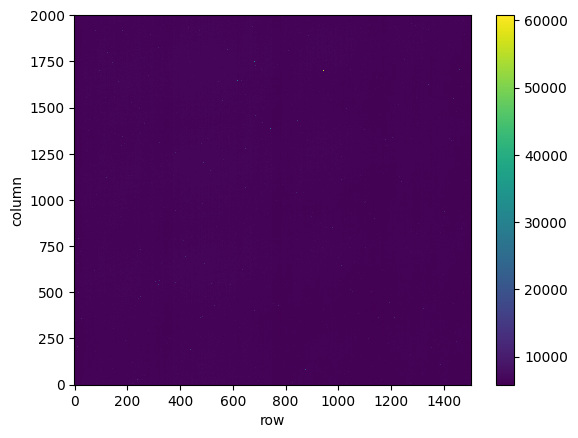

In [45]:
data[0].plot.imshow()

In [34]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1504                                                  
NAXIS2  =                 2001                                                  
EXTEND  =                    T                                                  
BSCALE  =                    1                                                  
BZERO   =                32768                                                  
DATE    = '2025-09-30T18:23:09.328479' / UTC time of this HDU's creation        
META_SEP= '******************** CSIE METADATA ********************'             
SHCOARSE=                   21 / [s] frame timestamp seconds                    
SHFINE  =                  545 / [ms] frame timestamp subseconds                
FRAME_ID=                535

In [19]:
(1.84*u.ms * len(all_fits_files)).to('s')

<Quantity 8.46216 s>